# 생체인증보안 1871085 멀티모달 1차 답안

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 383651669228129399
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10363614016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10600324329621261059
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [2]:
# 라이브러리 import
import PIL.Image as pilimg
import numpy as np
import glob
import matplotlib.pyplot as plt
import re

In [3]:
# 이미지 목록
images_face = sorted(glob.glob('./04_multimodal_training/*.BMP'))
images_iris = sorted(glob.glob('./04_multimodal_training/*.png'))

print(len(images_face), len(images_iris))

256 256


In [4]:
r = re.compile('\d+')

img_face = [] # 이미지
img_iris = [] # 이미지
label_face = [] # 라벨
label_iris = [] # 라벨

for fname in images_face:
    l = r.findall(fname)[1]
    label_face.append(l)
    im = pilimg.open(fname)
    pix = np.array(im)/255.
    pix = pix.reshape(pix.shape[0], pix.shape[1], 1)
    pix = tf.image.grayscale_to_rgb(tf.convert_to_tensor(pix)) # ResNet50 위해 rgb 이미지로 변환
    img_face.append(pix)
    
for fname in images_iris:
    l = r.findall(fname)[1]
    label_iris.append(l)
    im = pilimg.open(fname)
    im = im.resize((int(im.width*0.3), int(im.height*0.3))) # 이미지 줄이기
    pix = np.array(im)/255. # Normalize
    img_iris.append(pix)

In [5]:
X_face = np.array(img_face)
X_iris = np.array(img_iris)
print(X_face.shape, X_iris.shape)

(256, 56, 46, 3) (256, 172, 230, 3)


In [6]:
y_face = np.array(label_face, dtype='int32')
y_iris = np.array(label_iris, dtype='int32')

print(y_face) # face label
print(y_iris) # iris label

[ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11
 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17
 18 18 18 18 19 19 19 19 20 20 20 20 21 21 21 21 22 22 22 22 23 23 23 23
 24 24 24 24 25 25 25 25 26 26 26 26 27 27 27 27 28 28 28 28 29 29 29 29
 30 30 30 30 31 31 31 31 32 32 32 32 33 33 33 33 34 34 34 34 35 35 35 35
 36 36 36 36 37 37 37 37 38 38 38 38 39 39 39 39 40 40 40 40 41 41 41 41
 42 42 42 42 43 43 43 43 44 44 44 44 45 45 45 45 46 46 46 46 47 47 47 47
 48 48 48 48 49 49 49 49 50 50 50 50 51 51 51 51 52 52 52 52 53 53 53 53
 54 54 54 54 55 55 55 55 56 56 56 56 57 57 57 57 58 58 58 58 59 59 59 59
 60 60 60 60 61 61 61 61 62 62 62 62 63 63 63 63]
[ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11
 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17
 

(56, 46, 3)
0


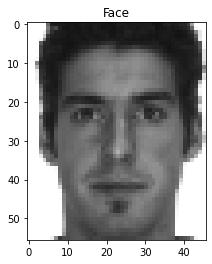

In [7]:
# 0번 사람의 얼굴 이미지
plt.title('Face')
plt.imshow(X_face[0])
print(X_face[0].shape)
print(y_face[0])

(172, 230, 3)
0


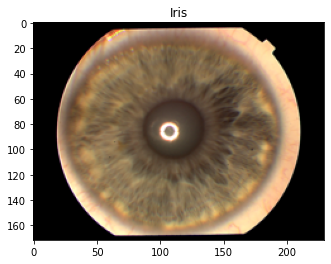

In [8]:
# 0번 사람의 홍채 이미지
plt.title('Iris')
plt.imshow(X_iris[0], cmap='gray')
print(X_iris[0].shape)
print(y_iris[0])

## Data Augmentation

In [9]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.Add(0,1.),
    iaa.GaussianBlur(sigma=(0.0, 0.9)),
    iaa.Fliplr(0.5), # 수평
    #iaa.Flipud(0.5) # 수직
], random_order=True)

def aug_data(X_data, y_data):
    augmentated_data = [] # 생성한 이미지
    augmentated_label = [] # 생성한 이미지의 라벨
    for i in range(len(X_data)):
        augs = [X_data[i]] * 9 # 이미지당 9개 추가 생성
        augs = seq.augment_images(augs)
        for aug in augs:
            augmentated_data.append(aug)
            augmentated_label.append(y_data[i])
    
    return augmentated_data, augmentated_label

In [10]:
face_x_d, face_y_d = aug_data(X_face.astype('float32'), y_face) # Face 이미지 생성
print(len(face_x_d), len(face_y_d))
iris_x_d, iris_y_d = aug_data(X_iris.astype('float32'), y_iris) # Iris 이미지 생성
print(len(iris_x_d), len(iris_y_d))

2304 2304
2304 2304


(56, 46, 3)
0


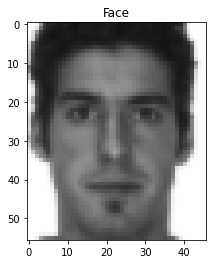

In [11]:
# 생성한 얼굴 이미지
plt.title('Face')
plt.imshow(face_x_d[0])
print(face_x_d[0].shape)
print(face_y_d[0])

(172, 230, 3)
0


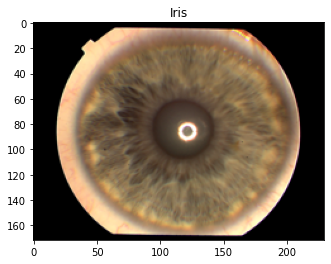

In [12]:
# 생성한 홍채 이미지
plt.title('Iris')
plt.imshow(iris_x_d[0])
print(iris_x_d[0].shape)
print(iris_y_d[0])

In [13]:
# 기존 이미지
print(X_face.shape)
print(y_face.shape)
print(X_iris.shape)
print(y_iris.shape)

# 생성한 이미지
face_x_d = np.array(face_x_d)
face_y_d = np.array(face_y_d)
print(face_x_d.shape)
print(face_y_d.shape)
iris_x_d = np.array(iris_x_d)
iris_y_d = np.array(iris_y_d)
print(iris_x_d.shape)
print(iris_y_d.shape)

(256, 56, 46, 3)
(256,)
(256, 172, 230, 3)
(256,)
(2304, 56, 46, 3)
(2304,)
(2304, 172, 230, 3)
(2304,)


In [14]:
# 기존 이미지, 생성 이미지 합치기
X_face = np.concatenate([X_face, face_x_d], axis=0)
y_face = np.concatenate([y_face, face_y_d], axis=0)
X_iris = np.concatenate([X_iris, iris_x_d], axis=0)
y_iris = np.concatenate([y_iris, iris_y_d], axis=0)
print(X_face.shape)
print(X_iris.shape)

(2560, 56, 46, 3)
(2560, 172, 230, 3)


# Data split

In [15]:
from sklearn.model_selection import train_test_split
X_train_face, X_test_face, y_train_face, y_test_face = train_test_split(X_face,y_face, test_size=0.3, shuffle=True, stratify=y_face, random_state=101)
X_iris_face, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris,y_iris, test_size=0.3, shuffle=True, stratify=y_iris, random_state=101)

### label 똑같이 나누어진 것 확인

In [16]:
print(np.array_equal(y_train_face,y_train_iris))
print(np.array_equal(y_test_face, y_test_iris))

True
True


In [17]:
X_train_face=X_train_face.astype('float32')
y_train_face=y_train_face.astype('int32') 
X_test_face=X_test_face.astype('float32')
y_test_face=y_test_face.astype('int32') 
X_train_iris=X_iris_face.astype('float32')
y_train_iris=y_train_iris.astype('int32') # y_train_face와 동일
X_test_iris=X_test_iris.astype('float32')
y_test_iris=y_test_iris.astype('int32') # y_test_face와 동일

In [18]:
print(X_train_face.shape, y_train_face.shape, X_test_face.shape, y_test_face.shape)
print(X_iris_face.shape, y_train_iris.shape, X_test_iris.shape, y_test_iris.shape)

(1792, 56, 46, 3) (1792,) (768, 56, 46, 3) (768,)
(1792, 172, 230, 3) (1792,) (768, 172, 230, 3) (768,)


In [19]:
y_train_data = y_train_face
y_test_data = y_test_face

# Model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50V2, VGG19
from tensorflow.keras.optimizers import Adam

In [59]:
def build_model_face():
    learning_rate = 0.00005
    METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy')
    ]
    input_ = Input(shape=X_face[0].shape, name='face_input')
    base_model = VGG19(include_top=False, input_tensor=input_)
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
    output = Dense(64, activation='softmax')(x)
    
    model = Model(input_, output)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=METRICS)
    return model

#build_model_face().summary()

In [60]:
def build_model_iris():
    learning_rate = 0.0001
    METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy')
    ]
    input_ = Input(shape=X_iris[0].shape, name='iris_input')
    base_modelB = ResNet50V2(include_top=False, input_tensor=input_)
    for layer in base_modelB.layers[:44]:
        layer.trainable=False
    
    y = base_modelB.output
    y = MaxPooling2D(pool_size=(2,2))(y)
    y = Flatten()(y)
    y = Dense(512, activation='relu', kernel_regularizer='l2')(y)
    y = Dropout(0.5)(y)
    y = Dense(128, activation='relu', kernel_regularizer='l2')(y)
    output = Dense(64, activation='softmax')(y)
    
    model = Model(input_, output)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=METRICS)
    return model

#build_model_iris().summary()

In [70]:
#Cross validation
from sklearn.model_selection import KFold
from keras.utils import to_categorical

kf = KFold(n_splits=4, shuffle=True, random_state=42)
all_history_face = [] # face 결과 저장
all_history_iris = [] # iris 결과 저장

def score_model(cv=None):
    if cv is None:
        cv = KFold(n_splits=4, random_state=42, shuffle=True)
        
    i=0
    for train_fold_index, val_fold_index in cv.split(X_train_face, y_train_data):
        # index를 split하는 것이기 때문에 face, iris에 동일하게 적용 가능 (random_state)
        
        i=i+1
        print('Fold #',i)
        
        # Get the training data
        X_train_face_fold = X_train_face[train_fold_index]
        X_train_iris_fold = X_train_iris[train_fold_index]
        y_train_fold = y_train_data[train_fold_index]
        
        # Get the validation data
        X_val_face_fold = X_train_face[val_fold_index]
        X_val_iris_fold = X_train_iris[val_fold_index]
        y_val_fold = y_train_data[val_fold_index]

        print(X_train_face_fold.shape)
        print(X_train_iris_fold.shape)
        print(y_val_fold.shape)
        
        # 원핫인코딩
        y_train_fold = to_categorical(y_train_fold, num_classes=64)
        y_val_fold = to_categorical(y_val_fold, num_classes=64)
        
        # Fit the model - Face
        print('<Train Face Model>')
        facemodel = build_model_face()
        facemodel_obj = facemodel.fit(X_train_face_fold, y_train_fold,
                              epochs=1000,
                              batch_size=128,
                              validation_data=(X_val_face_fold, y_val_fold),
                              verbose=1)
        facemodel.save('./model/face_model3_'+str(i)+'.h5')
        all_history_face.append(facemodel_obj.history)
        
        # Fit the model - Iris
        print('<Train Iris Model>')
        irismodel = build_model_iris()
        irismodel_obj = irismodel.fit(X_train_iris_fold, y_train_fold,
                              epochs=100,
                              #batch_size=32,
                              validation_data=(X_val_iris_fold, y_val_fold),
                              verbose=1)
        irismodel.save('./model/iris_model3_'+str(i)+'.h5')
        all_history_iris.append(irismodel_obj.history)
        
# Example of the model in action
score_model(cv=kf)

Fold # 1
(1344, 56, 46, 3)
(1344, 172, 230, 3)
(448,)
<Train Face Model>
Epoch 1/1000
11/11 [==============================] - 1s 55ms/step - loss: 6.3293 - accuracy: 0.0181 - val_loss: 6.3242 - val_accuracy: 0.0156
Epoch 2/1000
11/11 [==============================] - 0s 33ms/step - loss: 6.2622 - accuracy: 0.0217 - val_loss: 6.2743 - val_accuracy: 0.0179
Epoch 3/1000
11/11 [==============================] - 0s 32ms/step - loss: 6.2144 - accuracy: 0.0264 - val_loss: 6.2263 - val_accuracy: 0.0179
Epoch 4/1000
11/11 [==============================] - 0s 33ms/step - loss: 6.1762 - accuracy: 0.0300 - val_loss: 6.1798 - val_accuracy: 0.0179
Epoch 5/1000
11/11 [==============================] - 0s 34ms/step - loss: 6.1264 - accuracy: 0.0248 - val_loss: 6.1354 - val_accuracy: 0.0179
Epoch 6/1000
11/11 [==============================] - 0s 33ms/step - loss: 6.0943 - accuracy: 0.0271 - val_loss: 6.0919 - val_accuracy: 0.0156
Epoch 7/1000
11/11 [==============================] - 0s 33ms/step - 

Epoch 114/1000
11/11 [==============================] - 0s 34ms/step - loss: 3.1683 - accuracy: 0.7383 - val_loss: 3.2942 - val_accuracy: 0.6406
Epoch 115/1000
11/11 [==============================] - 0s 35ms/step - loss: 3.1750 - accuracy: 0.7237 - val_loss: 3.2780 - val_accuracy: 0.6451
Epoch 116/1000
11/11 [==============================] - 0s 34ms/step - loss: 3.1657 - accuracy: 0.7296 - val_loss: 3.2622 - val_accuracy: 0.6406
Epoch 117/1000
11/11 [==============================] - 0s 35ms/step - loss: 3.1275 - accuracy: 0.7334 - val_loss: 3.2460 - val_accuracy: 0.6451
Epoch 118/1000
11/11 [==============================] - 0s 35ms/step - loss: 3.1392 - accuracy: 0.7217 - val_loss: 3.2314 - val_accuracy: 0.6473
Epoch 119/1000
11/11 [==============================] - 0s 35ms/step - loss: 3.1124 - accuracy: 0.7304 - val_loss: 3.2169 - val_accuracy: 0.6473
Epoch 120/1000
11/11 [==============================] - 0s 35ms/step - loss: 3.1154 - accuracy: 0.7227 - val_loss: 3.2010 - val_ac

11/11 [==============================] - 0s 35ms/step - loss: 2.0409 - accuracy: 0.8864 - val_loss: 2.1942 - val_accuracy: 0.8103
Epoch 227/1000
11/11 [==============================] - 0s 35ms/step - loss: 2.0554 - accuracy: 0.8652 - val_loss: 2.1881 - val_accuracy: 0.8080
Epoch 228/1000
11/11 [==============================] - 0s 34ms/step - loss: 2.0414 - accuracy: 0.8805 - val_loss: 2.1813 - val_accuracy: 0.8103
Epoch 229/1000
11/11 [==============================] - 0s 35ms/step - loss: 2.0479 - accuracy: 0.8839 - val_loss: 2.1759 - val_accuracy: 0.8103
Epoch 230/1000
11/11 [==============================] - 0s 35ms/step - loss: 2.0375 - accuracy: 0.8711 - val_loss: 2.1706 - val_accuracy: 0.8080
Epoch 231/1000
11/11 [==============================] - 0s 34ms/step - loss: 2.0143 - accuracy: 0.8897 - val_loss: 2.1650 - val_accuracy: 0.8103
Epoch 232/1000
11/11 [==============================] - 0s 35ms/step - loss: 2.0206 - accuracy: 0.8700 - val_loss: 2.1585 - val_accuracy: 0.8170


11/11 [==============================] - 0s 33ms/step - loss: 1.6002 - accuracy: 0.9277 - val_loss: 1.7499 - val_accuracy: 0.8661
Epoch 339/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.5993 - accuracy: 0.9297 - val_loss: 1.7474 - val_accuracy: 0.8661
Epoch 340/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.6001 - accuracy: 0.9281 - val_loss: 1.7448 - val_accuracy: 0.8661
Epoch 341/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.6112 - accuracy: 0.9244 - val_loss: 1.7417 - val_accuracy: 0.8638
Epoch 342/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.6130 - accuracy: 0.9232 - val_loss: 1.7388 - val_accuracy: 0.8661
Epoch 343/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.5961 - accuracy: 0.9243 - val_loss: 1.7371 - val_accuracy: 0.8683
Epoch 344/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.5938 - accuracy: 0.9287 - val_loss: 1.7352 - val_accuracy: 0.8638


11/11 [==============================] - 1s 49ms/step - loss: 1.3462 - accuracy: 0.9520 - val_loss: 1.5073 - val_accuracy: 0.8973
Epoch 451/1000
11/11 [==============================] - 1s 49ms/step - loss: 1.3794 - accuracy: 0.9372 - val_loss: 1.5054 - val_accuracy: 0.8973
Epoch 452/1000
11/11 [==============================] - 1s 49ms/step - loss: 1.3608 - accuracy: 0.9402 - val_loss: 1.5030 - val_accuracy: 0.9018
Epoch 453/1000
11/11 [==============================] - 1s 48ms/step - loss: 1.3639 - accuracy: 0.9469 - val_loss: 1.5008 - val_accuracy: 0.9040
Epoch 454/1000
11/11 [==============================] - 1s 49ms/step - loss: 1.3407 - accuracy: 0.9505 - val_loss: 1.4990 - val_accuracy: 0.9018
Epoch 455/1000
11/11 [==============================] - 1s 57ms/step - loss: 1.3512 - accuracy: 0.9427 - val_loss: 1.4976 - val_accuracy: 0.8996
Epoch 456/1000
11/11 [==============================] - 1s 53ms/step - loss: 1.3637 - accuracy: 0.9433 - val_loss: 1.4947 - val_accuracy: 0.9018


11/11 [==============================] - 0s 33ms/step - loss: 1.2021 - accuracy: 0.9586 - val_loss: 1.3401 - val_accuracy: 0.9196
Epoch 563/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.2075 - accuracy: 0.9549 - val_loss: 1.3389 - val_accuracy: 0.9219
Epoch 564/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1954 - accuracy: 0.9567 - val_loss: 1.3377 - val_accuracy: 0.9219
Epoch 565/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.2089 - accuracy: 0.9494 - val_loss: 1.3363 - val_accuracy: 0.9196
Epoch 566/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1889 - accuracy: 0.9556 - val_loss: 1.3353 - val_accuracy: 0.9196
Epoch 567/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1897 - accuracy: 0.9580 - val_loss: 1.3340 - val_accuracy: 0.9196
Epoch 568/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.2036 - accuracy: 0.9604 - val_loss: 1.3321 - val_accuracy: 0.9196


11/11 [==============================] - 0s 33ms/step - loss: 1.0936 - accuracy: 0.9676 - val_loss: 1.2170 - val_accuracy: 0.9286
Epoch 675/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.0911 - accuracy: 0.9679 - val_loss: 1.2163 - val_accuracy: 0.9263
Epoch 676/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.0805 - accuracy: 0.9763 - val_loss: 1.2160 - val_accuracy: 0.9263
Epoch 677/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.0697 - accuracy: 0.9690 - val_loss: 1.2145 - val_accuracy: 0.9263
Epoch 678/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.0793 - accuracy: 0.9682 - val_loss: 1.2130 - val_accuracy: 0.9286
Epoch 679/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.0733 - accuracy: 0.9653 - val_loss: 1.2118 - val_accuracy: 0.9286
Epoch 680/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.0823 - accuracy: 0.9670 - val_loss: 1.2096 - val_accuracy: 0.9308


11/11 [==============================] - 0s 33ms/step - loss: 0.9979 - accuracy: 0.9719 - val_loss: 1.1183 - val_accuracy: 0.9420
Epoch 787/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9919 - accuracy: 0.9720 - val_loss: 1.1175 - val_accuracy: 0.9420
Epoch 788/1000
11/11 [==============================] - 0s 32ms/step - loss: 0.9992 - accuracy: 0.9781 - val_loss: 1.1177 - val_accuracy: 0.9397
Epoch 789/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9897 - accuracy: 0.9800 - val_loss: 1.1161 - val_accuracy: 0.9420
Epoch 790/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9866 - accuracy: 0.9778 - val_loss: 1.1158 - val_accuracy: 0.9397
Epoch 791/1000
11/11 [==============================] - 0s 32ms/step - loss: 0.9879 - accuracy: 0.9738 - val_loss: 1.1154 - val_accuracy: 0.9397
Epoch 792/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9888 - accuracy: 0.9765 - val_loss: 1.1145 - val_accuracy: 0.9420


11/11 [==============================] - 0s 33ms/step - loss: 0.9136 - accuracy: 0.9824 - val_loss: 1.0373 - val_accuracy: 0.9464
Epoch 899/1000
11/11 [==============================] - 0s 36ms/step - loss: 0.9072 - accuracy: 0.9863 - val_loss: 1.0368 - val_accuracy: 0.9464
Epoch 900/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9166 - accuracy: 0.9820 - val_loss: 1.0359 - val_accuracy: 0.9464
Epoch 901/1000
11/11 [==============================] - 0s 34ms/step - loss: 0.9115 - accuracy: 0.9846 - val_loss: 1.0357 - val_accuracy: 0.9464
Epoch 902/1000
11/11 [==============================] - 0s 34ms/step - loss: 0.9258 - accuracy: 0.9836 - val_loss: 1.0346 - val_accuracy: 0.9464
Epoch 903/1000
11/11 [==============================] - 0s 34ms/step - loss: 0.9174 - accuracy: 0.9842 - val_loss: 1.0342 - val_accuracy: 0.9487
Epoch 904/1000
11/11 [==============================] - 0s 35ms/step - loss: 0.9079 - accuracy: 0.9803 - val_loss: 1.0335 - val_accuracy: 0.9464


42/42 [==============================] - 5s 121ms/step - loss: 5.6432 - accuracy: 0.9915 - val_loss: 5.4028 - val_accuracy: 0.9978
Epoch 11/100
42/42 [==============================] - 5s 122ms/step - loss: 5.3438 - accuracy: 0.9965 - val_loss: 5.1363 - val_accuracy: 0.9978
Epoch 12/100
42/42 [==============================] - 5s 123ms/step - loss: 5.0780 - accuracy: 0.9960 - val_loss: 4.8786 - val_accuracy: 0.9955
Epoch 13/100
42/42 [==============================] - 5s 122ms/step - loss: 4.8249 - accuracy: 0.9961 - val_loss: 4.6738 - val_accuracy: 0.9888
Epoch 14/100
42/42 [==============================] - 5s 124ms/step - loss: 4.5781 - accuracy: 0.9990 - val_loss: 4.4094 - val_accuracy: 0.9978
Epoch 15/100
42/42 [==============================] - 5s 123ms/step - loss: 4.3497 - accuracy: 0.9986 - val_loss: 4.1819 - val_accuracy: 1.0000
Epoch 16/100
42/42 [==============================] - 5s 122ms/step - loss: 4.1493 - accuracy: 0.9933 - val_loss: 3.9784 - val_accuracy: 1.0000
Epoch

Epoch 67/100
42/42 [==============================] - 5s 124ms/step - loss: 0.4345 - accuracy: 1.0000 - val_loss: 0.4183 - val_accuracy: 1.0000
Epoch 68/100
42/42 [==============================] - 5s 122ms/step - loss: 0.4149 - accuracy: 1.0000 - val_loss: 0.3997 - val_accuracy: 1.0000
Epoch 69/100
42/42 [==============================] - 5s 124ms/step - loss: 0.3961 - accuracy: 1.0000 - val_loss: 0.3815 - val_accuracy: 1.0000
Epoch 70/100
42/42 [==============================] - 5s 123ms/step - loss: 0.3783 - accuracy: 1.0000 - val_loss: 0.3639 - val_accuracy: 1.0000
Epoch 71/100
42/42 [==============================] - 5s 121ms/step - loss: 0.3604 - accuracy: 1.0000 - val_loss: 0.3468 - val_accuracy: 1.0000
Epoch 72/100
42/42 [==============================] - 5s 122ms/step - loss: 0.3430 - accuracy: 1.0000 - val_loss: 0.3297 - val_accuracy: 1.0000
Epoch 73/100
42/42 [==============================] - 5s 124ms/step - loss: 0.3268 - accuracy: 1.0000 - val_loss: 0.3139 - val_accuracy:

Epoch 80/1000
11/11 [==============================] - 0s 33ms/step - loss: 3.8972 - accuracy: 0.5827 - val_loss: 4.0054 - val_accuracy: 0.4955
Epoch 81/1000
11/11 [==============================] - 0s 33ms/step - loss: 3.9012 - accuracy: 0.5778 - val_loss: 3.9838 - val_accuracy: 0.5067
Epoch 82/1000
11/11 [==============================] - 0s 33ms/step - loss: 3.8878 - accuracy: 0.5762 - val_loss: 3.9625 - val_accuracy: 0.5000
Epoch 83/1000
11/11 [==============================] - 0s 33ms/step - loss: 3.8740 - accuracy: 0.5731 - val_loss: 3.9425 - val_accuracy: 0.5089
Epoch 84/1000
11/11 [==============================] - 0s 32ms/step - loss: 3.8363 - accuracy: 0.5987 - val_loss: 3.9223 - val_accuracy: 0.5156
Epoch 85/1000
11/11 [==============================] - 0s 33ms/step - loss: 3.8084 - accuracy: 0.5996 - val_loss: 3.9032 - val_accuracy: 0.5089
Epoch 86/1000
11/11 [==============================] - 0s 33ms/step - loss: 3.7737 - accuracy: 0.6127 - val_loss: 3.8826 - val_accuracy:

11/11 [==============================] - 0s 33ms/step - loss: 2.3411 - accuracy: 0.8348 - val_loss: 2.5008 - val_accuracy: 0.7723
Epoch 193/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.3218 - accuracy: 0.8448 - val_loss: 2.4937 - val_accuracy: 0.7723
Epoch 194/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.3122 - accuracy: 0.8364 - val_loss: 2.4857 - val_accuracy: 0.7656
Epoch 195/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.3309 - accuracy: 0.8362 - val_loss: 2.4777 - val_accuracy: 0.7679
Epoch 196/1000
11/11 [==============================] - 0s 32ms/step - loss: 2.3052 - accuracy: 0.8417 - val_loss: 2.4691 - val_accuracy: 0.7701
Epoch 197/1000
11/11 [==============================] - 0s 32ms/step - loss: 2.2913 - accuracy: 0.8474 - val_loss: 2.4620 - val_accuracy: 0.7723
Epoch 198/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.2918 - accuracy: 0.8396 - val_loss: 2.4552 - val_accuracy: 0.7701


11/11 [==============================] - 0s 33ms/step - loss: 1.7679 - accuracy: 0.9085 - val_loss: 1.9099 - val_accuracy: 0.8571
Epoch 305/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.7354 - accuracy: 0.9148 - val_loss: 1.9057 - val_accuracy: 0.8571
Epoch 306/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.7286 - accuracy: 0.9083 - val_loss: 1.9017 - val_accuracy: 0.8571
Epoch 307/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.7379 - accuracy: 0.9265 - val_loss: 1.8981 - val_accuracy: 0.8571
Epoch 308/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.7320 - accuracy: 0.9058 - val_loss: 1.8950 - val_accuracy: 0.8571
Epoch 309/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.7058 - accuracy: 0.9195 - val_loss: 1.8925 - val_accuracy: 0.8571
Epoch 310/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.7673 - accuracy: 0.8995 - val_loss: 1.8893 - val_accuracy: 0.8571


11/11 [==============================] - 0s 34ms/step - loss: 1.4588 - accuracy: 0.9451 - val_loss: 1.6092 - val_accuracy: 0.8951
Epoch 417/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.4540 - accuracy: 0.9401 - val_loss: 1.6074 - val_accuracy: 0.8929
Epoch 418/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.4433 - accuracy: 0.9442 - val_loss: 1.6056 - val_accuracy: 0.8929
Epoch 419/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.4319 - accuracy: 0.9403 - val_loss: 1.6028 - val_accuracy: 0.8951
Epoch 420/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.4705 - accuracy: 0.9343 - val_loss: 1.6008 - val_accuracy: 0.8929
Epoch 421/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.4339 - accuracy: 0.9524 - val_loss: 1.5988 - val_accuracy: 0.8951
Epoch 422/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.4526 - accuracy: 0.9350 - val_loss: 1.5964 - val_accuracy: 0.8973


11/11 [==============================] - 0s 32ms/step - loss: 1.2591 - accuracy: 0.9637 - val_loss: 1.4156 - val_accuracy: 0.9152
Epoch 529/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.2649 - accuracy: 0.9624 - val_loss: 1.4137 - val_accuracy: 0.9152
Epoch 530/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.2531 - accuracy: 0.9623 - val_loss: 1.4122 - val_accuracy: 0.9152
Epoch 531/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.2727 - accuracy: 0.9540 - val_loss: 1.4112 - val_accuracy: 0.9152
Epoch 532/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.2664 - accuracy: 0.9592 - val_loss: 1.4101 - val_accuracy: 0.9152
Epoch 533/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.2644 - accuracy: 0.9544 - val_loss: 1.4085 - val_accuracy: 0.9152
Epoch 534/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.2722 - accuracy: 0.9619 - val_loss: 1.4084 - val_accuracy: 0.9174


11/11 [==============================] - 0s 42ms/step - loss: 1.1186 - accuracy: 0.9719 - val_loss: 1.2752 - val_accuracy: 0.9196
Epoch 641/1000
11/11 [==============================] - 0s 40ms/step - loss: 1.1303 - accuracy: 0.9654 - val_loss: 1.2735 - val_accuracy: 0.9219
Epoch 642/1000
11/11 [==============================] - 0s 43ms/step - loss: 1.1362 - accuracy: 0.9636 - val_loss: 1.2732 - val_accuracy: 0.9196
Epoch 643/1000
11/11 [==============================] - 0s 41ms/step - loss: 1.1332 - accuracy: 0.9647 - val_loss: 1.2720 - val_accuracy: 0.9174
Epoch 644/1000
11/11 [==============================] - 1s 49ms/step - loss: 1.1274 - accuracy: 0.9687 - val_loss: 1.2705 - val_accuracy: 0.9174
Epoch 645/1000
11/11 [==============================] - 0s 40ms/step - loss: 1.1265 - accuracy: 0.9654 - val_loss: 1.2701 - val_accuracy: 0.9174
Epoch 646/1000
11/11 [==============================] - 0s 40ms/step - loss: 1.1308 - accuracy: 0.9681 - val_loss: 1.2695 - val_accuracy: 0.9174


11/11 [==============================] - 0s 39ms/step - loss: 1.0330 - accuracy: 0.9725 - val_loss: 1.1644 - val_accuracy: 0.9330
Epoch 753/1000
11/11 [==============================] - 0s 39ms/step - loss: 1.0389 - accuracy: 0.9699 - val_loss: 1.1634 - val_accuracy: 0.9330
Epoch 754/1000
11/11 [==============================] - 0s 36ms/step - loss: 1.0537 - accuracy: 0.9733 - val_loss: 1.1626 - val_accuracy: 0.9330
Epoch 755/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.0211 - accuracy: 0.9776 - val_loss: 1.1619 - val_accuracy: 0.9330
Epoch 756/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.0346 - accuracy: 0.9735 - val_loss: 1.1601 - val_accuracy: 0.9330
Epoch 757/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.0351 - accuracy: 0.9763 - val_loss: 1.1594 - val_accuracy: 0.9330
Epoch 758/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.0189 - accuracy: 0.9761 - val_loss: 1.1597 - val_accuracy: 0.9330


11/11 [==============================] - 0s 34ms/step - loss: 0.9579 - accuracy: 0.9765 - val_loss: 1.0741 - val_accuracy: 0.9442
Epoch 865/1000
11/11 [==============================] - 0s 34ms/step - loss: 0.9440 - accuracy: 0.9771 - val_loss: 1.0733 - val_accuracy: 0.9442
Epoch 866/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9535 - accuracy: 0.9778 - val_loss: 1.0723 - val_accuracy: 0.9442
Epoch 867/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9343 - accuracy: 0.9786 - val_loss: 1.0714 - val_accuracy: 0.9442
Epoch 868/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9394 - accuracy: 0.9787 - val_loss: 1.0713 - val_accuracy: 0.9420
Epoch 869/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9449 - accuracy: 0.9795 - val_loss: 1.0696 - val_accuracy: 0.9442
Epoch 870/1000
11/11 [==============================] - 0s 32ms/step - loss: 0.9566 - accuracy: 0.9748 - val_loss: 1.0686 - val_accuracy: 0.9442


11/11 [==============================] - 0s 33ms/step - loss: 0.8894 - accuracy: 0.9810 - val_loss: 0.9983 - val_accuracy: 0.9464
Epoch 977/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.8853 - accuracy: 0.9807 - val_loss: 0.9979 - val_accuracy: 0.9464
Epoch 978/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.8830 - accuracy: 0.9854 - val_loss: 0.9965 - val_accuracy: 0.9464
Epoch 979/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.8845 - accuracy: 0.9802 - val_loss: 0.9964 - val_accuracy: 0.9464
Epoch 980/1000
11/11 [==============================] - 0s 39ms/step - loss: 0.8713 - accuracy: 0.9880 - val_loss: 0.9953 - val_accuracy: 0.9487
Epoch 981/1000
11/11 [==============================] - 0s 35ms/step - loss: 0.8781 - accuracy: 0.9866 - val_loss: 0.9951 - val_accuracy: 0.9464
Epoch 982/1000
11/11 [==============================] - 0s 38ms/step - loss: 0.8643 - accuracy: 0.9887 - val_loss: 0.9953 - val_accuracy: 0.9464


Epoch 33/100
42/42 [==============================] - 5s 121ms/step - loss: 1.8611 - accuracy: 0.9999 - val_loss: 1.7983 - val_accuracy: 1.0000
Epoch 34/100
42/42 [==============================] - 5s 122ms/step - loss: 1.7829 - accuracy: 0.9980 - val_loss: 1.7219 - val_accuracy: 1.0000
Epoch 35/100
42/42 [==============================] - 5s 126ms/step - loss: 1.7057 - accuracy: 1.0000 - val_loss: 1.6498 - val_accuracy: 0.9978
Epoch 36/100
42/42 [==============================] - 5s 125ms/step - loss: 1.6264 - accuracy: 1.0000 - val_loss: 1.5739 - val_accuracy: 0.9978
Epoch 37/100
42/42 [==============================] - 5s 121ms/step - loss: 1.5540 - accuracy: 1.0000 - val_loss: 1.5014 - val_accuracy: 1.0000
Epoch 38/100
42/42 [==============================] - 5s 122ms/step - loss: 1.4837 - accuracy: 1.0000 - val_loss: 1.4368 - val_accuracy: 0.9978
Epoch 39/100
42/42 [==============================] - 5s 123ms/step - loss: 1.4167 - accuracy: 1.0000 - val_loss: 1.3708 - val_accuracy:

Epoch 90/100
42/42 [==============================] - 5s 122ms/step - loss: 0.4018 - accuracy: 0.9909 - val_loss: 0.4076 - val_accuracy: 0.9844
Epoch 91/100
42/42 [==============================] - 5s 122ms/step - loss: 0.3368 - accuracy: 0.9982 - val_loss: 0.3296 - val_accuracy: 0.9933
Epoch 92/100
42/42 [==============================] - 5s 122ms/step - loss: 0.3173 - accuracy: 0.9952 - val_loss: 0.3243 - val_accuracy: 0.9933
Epoch 93/100
42/42 [==============================] - 5s 121ms/step - loss: 0.2947 - accuracy: 0.9953 - val_loss: 0.3562 - val_accuracy: 0.9888
Epoch 94/100
42/42 [==============================] - 5s 128ms/step - loss: 0.2732 - accuracy: 0.9974 - val_loss: 0.2803 - val_accuracy: 0.9933
Epoch 95/100
42/42 [==============================] - 5s 131ms/step - loss: 0.2451 - accuracy: 0.9999 - val_loss: 0.2617 - val_accuracy: 0.9933
Epoch 96/100
42/42 [==============================] - 5s 130ms/step - loss: 0.2324 - accuracy: 0.9971 - val_loss: 0.2435 - val_accuracy:

Epoch 103/1000
11/11 [==============================] - 0s 40ms/step - loss: 3.4524 - accuracy: 0.6314 - val_loss: 3.5584 - val_accuracy: 0.5424
Epoch 104/1000
11/11 [==============================] - 0s 40ms/step - loss: 3.4102 - accuracy: 0.6493 - val_loss: 3.5405 - val_accuracy: 0.5469
Epoch 105/1000
11/11 [==============================] - 0s 38ms/step - loss: 3.4277 - accuracy: 0.6053 - val_loss: 3.5233 - val_accuracy: 0.5469
Epoch 106/1000
11/11 [==============================] - 0s 37ms/step - loss: 3.3836 - accuracy: 0.6419 - val_loss: 3.5065 - val_accuracy: 0.5469
Epoch 107/1000
11/11 [==============================] - 0s 35ms/step - loss: 3.3798 - accuracy: 0.6353 - val_loss: 3.4902 - val_accuracy: 0.5536
Epoch 108/1000
11/11 [==============================] - 0s 35ms/step - loss: 3.3703 - accuracy: 0.6202 - val_loss: 3.4731 - val_accuracy: 0.5513
Epoch 109/1000
11/11 [==============================] - 0s 37ms/step - loss: 3.3379 - accuracy: 0.6432 - val_loss: 3.4569 - val_ac

11/11 [==============================] - 0s 37ms/step - loss: 2.1666 - accuracy: 0.8337 - val_loss: 2.3241 - val_accuracy: 0.7723
Epoch 216/1000
11/11 [==============================] - 0s 36ms/step - loss: 2.1491 - accuracy: 0.8449 - val_loss: 2.3179 - val_accuracy: 0.7746
Epoch 217/1000
11/11 [==============================] - 0s 38ms/step - loss: 2.1739 - accuracy: 0.8237 - val_loss: 2.3113 - val_accuracy: 0.7723
Epoch 218/1000
11/11 [==============================] - 0s 37ms/step - loss: 2.1631 - accuracy: 0.8188 - val_loss: 2.3045 - val_accuracy: 0.7746
Epoch 219/1000
11/11 [==============================] - 0s 36ms/step - loss: 2.1229 - accuracy: 0.8470 - val_loss: 2.2979 - val_accuracy: 0.7812
Epoch 220/1000
11/11 [==============================] - 0s 37ms/step - loss: 2.1435 - accuracy: 0.8356 - val_loss: 2.2924 - val_accuracy: 0.7812
Epoch 221/1000
11/11 [==============================] - 0s 36ms/step - loss: 2.1222 - accuracy: 0.8323 - val_loss: 2.2866 - val_accuracy: 0.7790


11/11 [==============================] - 1s 70ms/step - loss: 1.6519 - accuracy: 0.9208 - val_loss: 1.8179 - val_accuracy: 0.8728
Epoch 328/1000
11/11 [==============================] - 1s 49ms/step - loss: 1.6477 - accuracy: 0.9173 - val_loss: 1.8151 - val_accuracy: 0.8772
Epoch 329/1000
11/11 [==============================] - 1s 51ms/step - loss: 1.6686 - accuracy: 0.9218 - val_loss: 1.8120 - val_accuracy: 0.8772
Epoch 330/1000
11/11 [==============================] - 1s 48ms/step - loss: 1.6448 - accuracy: 0.9184 - val_loss: 1.8092 - val_accuracy: 0.8772
Epoch 331/1000
11/11 [==============================] - 1s 59ms/step - loss: 1.6564 - accuracy: 0.9235 - val_loss: 1.8057 - val_accuracy: 0.8795
Epoch 332/1000
11/11 [==============================] - 1s 49ms/step - loss: 1.6255 - accuracy: 0.9264 - val_loss: 1.8020 - val_accuracy: 0.8795
Epoch 333/1000
11/11 [==============================] - 1s 52ms/step - loss: 1.6260 - accuracy: 0.9214 - val_loss: 1.7991 - val_accuracy: 0.8817


11/11 [==============================] - 0s 38ms/step - loss: 1.4076 - accuracy: 0.9511 - val_loss: 1.5529 - val_accuracy: 0.9152
Epoch 440/1000
11/11 [==============================] - 0s 36ms/step - loss: 1.3946 - accuracy: 0.9513 - val_loss: 1.5506 - val_accuracy: 0.9152
Epoch 441/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.4017 - accuracy: 0.9529 - val_loss: 1.5494 - val_accuracy: 0.9152
Epoch 442/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.3938 - accuracy: 0.9445 - val_loss: 1.5468 - val_accuracy: 0.9152
Epoch 443/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.3950 - accuracy: 0.9401 - val_loss: 1.5445 - val_accuracy: 0.9174
Epoch 444/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.3950 - accuracy: 0.9422 - val_loss: 1.5422 - val_accuracy: 0.9152
Epoch 445/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.3795 - accuracy: 0.9522 - val_loss: 1.5410 - val_accuracy: 0.9152


11/11 [==============================] - 0s 35ms/step - loss: 1.2241 - accuracy: 0.9667 - val_loss: 1.3774 - val_accuracy: 0.9286
Epoch 552/1000
11/11 [==============================] - 0s 36ms/step - loss: 1.2211 - accuracy: 0.9641 - val_loss: 1.3761 - val_accuracy: 0.9286
Epoch 553/1000
11/11 [==============================] - 0s 36ms/step - loss: 1.2193 - accuracy: 0.9648 - val_loss: 1.3751 - val_accuracy: 0.9286
Epoch 554/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.2378 - accuracy: 0.9586 - val_loss: 1.3733 - val_accuracy: 0.9286
Epoch 555/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.2205 - accuracy: 0.9664 - val_loss: 1.3717 - val_accuracy: 0.9286
Epoch 556/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.2261 - accuracy: 0.9679 - val_loss: 1.3703 - val_accuracy: 0.9308
Epoch 557/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.2206 - accuracy: 0.9622 - val_loss: 1.3693 - val_accuracy: 0.9308


11/11 [==============================] - 0s 34ms/step - loss: 1.0997 - accuracy: 0.9787 - val_loss: 1.2477 - val_accuracy: 0.9420
Epoch 664/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1050 - accuracy: 0.9749 - val_loss: 1.2464 - val_accuracy: 0.9420
Epoch 665/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1187 - accuracy: 0.9805 - val_loss: 1.2456 - val_accuracy: 0.9420
Epoch 666/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.0966 - accuracy: 0.9758 - val_loss: 1.2443 - val_accuracy: 0.9442
Epoch 667/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1044 - accuracy: 0.9744 - val_loss: 1.2434 - val_accuracy: 0.9420
Epoch 668/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.1022 - accuracy: 0.9753 - val_loss: 1.2425 - val_accuracy: 0.9420
Epoch 669/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1057 - accuracy: 0.9800 - val_loss: 1.2408 - val_accuracy: 0.9420


11/11 [==============================] - 0s 33ms/step - loss: 1.0164 - accuracy: 0.9768 - val_loss: 1.1448 - val_accuracy: 0.9487
Epoch 776/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.0217 - accuracy: 0.9766 - val_loss: 1.1436 - val_accuracy: 0.9509
Epoch 777/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.0150 - accuracy: 0.9772 - val_loss: 1.1432 - val_accuracy: 0.9487
Epoch 778/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.0155 - accuracy: 0.9732 - val_loss: 1.1419 - val_accuracy: 0.9487
Epoch 779/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.0144 - accuracy: 0.9754 - val_loss: 1.1404 - val_accuracy: 0.9487
Epoch 780/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.0141 - accuracy: 0.9788 - val_loss: 1.1398 - val_accuracy: 0.9509
Epoch 781/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.0061 - accuracy: 0.9802 - val_loss: 1.1396 - val_accuracy: 0.9487


11/11 [==============================] - 0s 33ms/step - loss: 0.9421 - accuracy: 0.9790 - val_loss: 1.0585 - val_accuracy: 0.9621
Epoch 888/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9258 - accuracy: 0.9809 - val_loss: 1.0583 - val_accuracy: 0.9598
Epoch 889/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9279 - accuracy: 0.9837 - val_loss: 1.0578 - val_accuracy: 0.9598
Epoch 890/1000
11/11 [==============================] - 0s 35ms/step - loss: 0.9261 - accuracy: 0.9837 - val_loss: 1.0569 - val_accuracy: 0.9621
Epoch 891/1000
11/11 [==============================] - 0s 35ms/step - loss: 0.9323 - accuracy: 0.9767 - val_loss: 1.0553 - val_accuracy: 0.9643
Epoch 892/1000
11/11 [==============================] - 0s 35ms/step - loss: 0.9288 - accuracy: 0.9806 - val_loss: 1.0550 - val_accuracy: 0.9621
Epoch 893/1000
11/11 [==============================] - 0s 37ms/step - loss: 0.9289 - accuracy: 0.9805 - val_loss: 1.0546 - val_accuracy: 0.9621


11/11 [==============================] - 0s 35ms/step - loss: 0.8650 - accuracy: 0.9873 - val_loss: 0.9879 - val_accuracy: 0.9688
Epoch 1000/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.8726 - accuracy: 0.9778 - val_loss: 0.9872 - val_accuracy: 0.9688
<Train Iris Model>
Epoch 1/100
42/42 [==============================] - 9s 134ms/step - loss: 16.3127 - accuracy: 0.1005 - val_loss: 13.1261 - val_accuracy: 0.1496
Epoch 2/100
42/42 [==============================] - 5s 120ms/step - loss: 10.6584 - accuracy: 0.6755 - val_loss: 9.4535 - val_accuracy: 0.7768
Epoch 3/100
42/42 [==============================] - 5s 125ms/step - loss: 8.6363 - accuracy: 0.9364 - val_loss: 7.8959 - val_accuracy: 0.9665
Epoch 4/100
42/42 [==============================] - 6s 133ms/step - loss: 7.8178 - accuracy: 0.9503 - val_loss: 7.2565 - val_accuracy: 0.9978
Epoch 5/100
42/42 [==============================] - 5s 129ms/step - loss: 7.2090 - accuracy: 0.9684 - val_loss: 6.8025 - val_accu

Epoch 56/100
42/42 [==============================] - 5s 124ms/step - loss: 0.6881 - accuracy: 1.0000 - val_loss: 0.6649 - val_accuracy: 1.0000
Epoch 57/100
42/42 [==============================] - 5s 121ms/step - loss: 0.6583 - accuracy: 0.9998 - val_loss: 0.6357 - val_accuracy: 1.0000
Epoch 58/100
42/42 [==============================] - 5s 122ms/step - loss: 0.6306 - accuracy: 1.0000 - val_loss: 0.6083 - val_accuracy: 1.0000
Epoch 59/100
42/42 [==============================] - 5s 120ms/step - loss: 0.6021 - accuracy: 1.0000 - val_loss: 0.5808 - val_accuracy: 1.0000
Epoch 60/100
42/42 [==============================] - 5s 121ms/step - loss: 0.5750 - accuracy: 1.0000 - val_loss: 0.5546 - val_accuracy: 1.0000
Epoch 61/100
42/42 [==============================] - 5s 122ms/step - loss: 0.5490 - accuracy: 1.0000 - val_loss: 0.5295 - val_accuracy: 1.0000
Epoch 62/100
42/42 [==============================] - 5s 121ms/step - loss: 0.5243 - accuracy: 1.0000 - val_loss: 0.5058 - val_accuracy:

Epoch 69/1000
11/11 [==============================] - 0s 34ms/step - loss: 4.1775 - accuracy: 0.4320 - val_loss: 4.2469 - val_accuracy: 0.3661
Epoch 70/1000
11/11 [==============================] - 0s 33ms/step - loss: 4.1306 - accuracy: 0.4624 - val_loss: 4.2242 - val_accuracy: 0.3750
Epoch 71/1000
11/11 [==============================] - 0s 33ms/step - loss: 4.1089 - accuracy: 0.4778 - val_loss: 4.2004 - val_accuracy: 0.3862
Epoch 72/1000
11/11 [==============================] - 0s 33ms/step - loss: 4.0939 - accuracy: 0.4577 - val_loss: 4.1760 - val_accuracy: 0.3951
Epoch 73/1000
11/11 [==============================] - 0s 33ms/step - loss: 4.0620 - accuracy: 0.4865 - val_loss: 4.1536 - val_accuracy: 0.3996
Epoch 74/1000
11/11 [==============================] - 0s 33ms/step - loss: 4.0656 - accuracy: 0.4645 - val_loss: 4.1298 - val_accuracy: 0.4196
Epoch 75/1000
11/11 [==============================] - 0s 33ms/step - loss: 4.0331 - accuracy: 0.4931 - val_loss: 4.1070 - val_accuracy:

Epoch 126/1000
11/11 [==============================] - 0s 33ms/step - loss: 3.0255 - accuracy: 0.6906 - val_loss: 3.1408 - val_accuracy: 0.6027
Epoch 127/1000
11/11 [==============================] - 0s 34ms/step - loss: 3.0094 - accuracy: 0.6980 - val_loss: 3.1260 - val_accuracy: 0.6116
Epoch 128/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.9846 - accuracy: 0.7143 - val_loss: 3.1118 - val_accuracy: 0.6116
Epoch 129/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.9745 - accuracy: 0.7002 - val_loss: 3.0967 - val_accuracy: 0.6138
Epoch 130/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.9815 - accuracy: 0.7120 - val_loss: 3.0830 - val_accuracy: 0.6183
Epoch 131/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.9203 - accuracy: 0.7370 - val_loss: 3.0694 - val_accuracy: 0.6183
Epoch 132/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.9319 - accuracy: 0.7169 - val_loss: 3.0551 - val_ac

11/11 [==============================] - 0s 33ms/step - loss: 1.9596 - accuracy: 0.8771 - val_loss: 2.1446 - val_accuracy: 0.8147
Epoch 239/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.9856 - accuracy: 0.8625 - val_loss: 2.1387 - val_accuracy: 0.8125
Epoch 240/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.9689 - accuracy: 0.8598 - val_loss: 2.1337 - val_accuracy: 0.8125
Epoch 241/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.9568 - accuracy: 0.8780 - val_loss: 2.1287 - val_accuracy: 0.8147
Epoch 242/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.9433 - accuracy: 0.8737 - val_loss: 2.1233 - val_accuracy: 0.8192
Epoch 243/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.9429 - accuracy: 0.8768 - val_loss: 2.1184 - val_accuracy: 0.8147
Epoch 244/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.9660 - accuracy: 0.8553 - val_loss: 2.1131 - val_accuracy: 0.8192


11/11 [==============================] - 0s 33ms/step - loss: 1.5526 - accuracy: 0.9310 - val_loss: 1.7388 - val_accuracy: 0.8616
Epoch 351/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.5449 - accuracy: 0.9332 - val_loss: 1.7358 - val_accuracy: 0.8594
Epoch 352/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.5549 - accuracy: 0.9223 - val_loss: 1.7324 - val_accuracy: 0.8616
Epoch 353/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.5766 - accuracy: 0.9219 - val_loss: 1.7293 - val_accuracy: 0.8616
Epoch 354/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.5420 - accuracy: 0.9228 - val_loss: 1.7267 - val_accuracy: 0.8616
Epoch 355/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.5494 - accuracy: 0.9204 - val_loss: 1.7238 - val_accuracy: 0.8616
Epoch 356/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.5560 - accuracy: 0.9233 - val_loss: 1.7213 - val_accuracy: 0.8683


11/11 [==============================] - 0s 35ms/step - loss: 1.3210 - accuracy: 0.9582 - val_loss: 1.5046 - val_accuracy: 0.8996
Epoch 463/1000
11/11 [==============================] - 0s 36ms/step - loss: 1.3313 - accuracy: 0.9551 - val_loss: 1.5018 - val_accuracy: 0.8996
Epoch 464/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.3396 - accuracy: 0.9505 - val_loss: 1.5000 - val_accuracy: 0.8996
Epoch 465/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.3135 - accuracy: 0.9580 - val_loss: 1.4984 - val_accuracy: 0.8996
Epoch 466/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.3430 - accuracy: 0.9513 - val_loss: 1.4961 - val_accuracy: 0.8996
Epoch 467/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.3264 - accuracy: 0.9532 - val_loss: 1.4948 - val_accuracy: 0.8996
Epoch 468/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.3313 - accuracy: 0.9579 - val_loss: 1.4942 - val_accuracy: 0.8996


11/11 [==============================] - 0s 33ms/step - loss: 1.1793 - accuracy: 0.9719 - val_loss: 1.3454 - val_accuracy: 0.9018
Epoch 575/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1705 - accuracy: 0.9683 - val_loss: 1.3435 - val_accuracy: 0.9018
Epoch 576/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1884 - accuracy: 0.9649 - val_loss: 1.3421 - val_accuracy: 0.9018
Epoch 577/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1536 - accuracy: 0.9673 - val_loss: 1.3405 - val_accuracy: 0.9040
Epoch 578/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1719 - accuracy: 0.9681 - val_loss: 1.3393 - val_accuracy: 0.9040
Epoch 579/1000
11/11 [==============================] - 0s 32ms/step - loss: 1.1737 - accuracy: 0.9731 - val_loss: 1.3374 - val_accuracy: 0.9040
Epoch 580/1000
11/11 [==============================] - 0s 33ms/step - loss: 1.1782 - accuracy: 0.9652 - val_loss: 1.3360 - val_accuracy: 0.9040


11/11 [==============================] - 0s 35ms/step - loss: 1.0700 - accuracy: 0.9803 - val_loss: 1.2227 - val_accuracy: 0.9174
Epoch 687/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.0811 - accuracy: 0.9750 - val_loss: 1.2218 - val_accuracy: 0.9174
Epoch 688/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.0639 - accuracy: 0.9806 - val_loss: 1.2212 - val_accuracy: 0.9174
Epoch 689/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.0653 - accuracy: 0.9813 - val_loss: 1.2201 - val_accuracy: 0.9174
Epoch 690/1000
11/11 [==============================] - 0s 36ms/step - loss: 1.0586 - accuracy: 0.9808 - val_loss: 1.2191 - val_accuracy: 0.9174
Epoch 691/1000
11/11 [==============================] - 0s 34ms/step - loss: 1.0568 - accuracy: 0.9785 - val_loss: 1.2179 - val_accuracy: 0.9174
Epoch 692/1000
11/11 [==============================] - 0s 35ms/step - loss: 1.0562 - accuracy: 0.9772 - val_loss: 1.2168 - val_accuracy: 0.9174


11/11 [==============================] - 0s 33ms/step - loss: 0.9769 - accuracy: 0.9808 - val_loss: 1.1262 - val_accuracy: 0.9241
Epoch 799/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9654 - accuracy: 0.9815 - val_loss: 1.1264 - val_accuracy: 0.9263
Epoch 800/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9651 - accuracy: 0.9847 - val_loss: 1.1252 - val_accuracy: 0.9241
Epoch 801/1000
11/11 [==============================] - 0s 34ms/step - loss: 0.9581 - accuracy: 0.9851 - val_loss: 1.1242 - val_accuracy: 0.9241
Epoch 802/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9602 - accuracy: 0.9869 - val_loss: 1.1231 - val_accuracy: 0.9263
Epoch 803/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9702 - accuracy: 0.9831 - val_loss: 1.1226 - val_accuracy: 0.9263
Epoch 804/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.9658 - accuracy: 0.9810 - val_loss: 1.1218 - val_accuracy: 0.9263


11/11 [==============================] - 0s 33ms/step - loss: 0.8954 - accuracy: 0.9863 - val_loss: 1.0479 - val_accuracy: 0.9330
Epoch 911/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.8986 - accuracy: 0.9839 - val_loss: 1.0466 - val_accuracy: 0.9330
Epoch 912/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.8940 - accuracy: 0.9876 - val_loss: 1.0466 - val_accuracy: 0.9330
Epoch 913/1000
11/11 [==============================] - 0s 35ms/step - loss: 0.8880 - accuracy: 0.9862 - val_loss: 1.0459 - val_accuracy: 0.9308
Epoch 914/1000
11/11 [==============================] - 0s 35ms/step - loss: 0.8777 - accuracy: 0.9873 - val_loss: 1.0446 - val_accuracy: 0.9308
Epoch 915/1000
11/11 [==============================] - 0s 35ms/step - loss: 0.8830 - accuracy: 0.9898 - val_loss: 1.0447 - val_accuracy: 0.9308
Epoch 916/1000
11/11 [==============================] - 0s 33ms/step - loss: 0.8956 - accuracy: 0.9823 - val_loss: 1.0442 - val_accuracy: 0.9330


42/42 [==============================] - 5s 121ms/step - loss: 3.0138 - accuracy: 0.9999 - val_loss: 2.9063 - val_accuracy: 1.0000
Epoch 23/100
42/42 [==============================] - 5s 125ms/step - loss: 2.8727 - accuracy: 1.0000 - val_loss: 2.7687 - val_accuracy: 1.0000
Epoch 24/100
42/42 [==============================] - 5s 121ms/step - loss: 2.7452 - accuracy: 0.9950 - val_loss: 2.6753 - val_accuracy: 0.9955
Epoch 25/100
42/42 [==============================] - 5s 120ms/step - loss: 2.6337 - accuracy: 0.9955 - val_loss: 2.5508 - val_accuracy: 0.9933
Epoch 26/100
42/42 [==============================] - 5s 123ms/step - loss: 2.5271 - accuracy: 0.9909 - val_loss: 2.4590 - val_accuracy: 0.9933
Epoch 27/100
42/42 [==============================] - 5s 123ms/step - loss: 2.4276 - accuracy: 0.9954 - val_loss: 2.3281 - val_accuracy: 1.0000
Epoch 28/100
42/42 [==============================] - 5s 121ms/step - loss: 2.3075 - accuracy: 0.9999 - val_loss: 2.2226 - val_accuracy: 1.0000
Epoch

Epoch 79/100
42/42 [==============================] - 5s 123ms/step - loss: 0.2046 - accuracy: 1.0000 - val_loss: 0.1957 - val_accuracy: 1.0000
Epoch 80/100
42/42 [==============================] - 5s 121ms/step - loss: 0.1968 - accuracy: 1.0000 - val_loss: 0.1882 - val_accuracy: 1.0000
Epoch 81/100
42/42 [==============================] - 5s 123ms/step - loss: 0.1863 - accuracy: 1.0000 - val_loss: 0.1774 - val_accuracy: 1.0000
Epoch 82/100
42/42 [==============================] - 5s 124ms/step - loss: 0.1773 - accuracy: 1.0000 - val_loss: 0.1685 - val_accuracy: 1.0000
Epoch 83/100
42/42 [==============================] - 5s 119ms/step - loss: 0.1674 - accuracy: 1.0000 - val_loss: 0.1591 - val_accuracy: 1.0000
Epoch 84/100
42/42 [==============================] - 5s 120ms/step - loss: 0.1578 - accuracy: 1.0000 - val_loss: 0.1502 - val_accuracy: 1.0000
Epoch 85/100
42/42 [==============================] - 5s 121ms/step - loss: 0.1496 - accuracy: 1.0000 - val_loss: 0.1426 - val_accuracy:

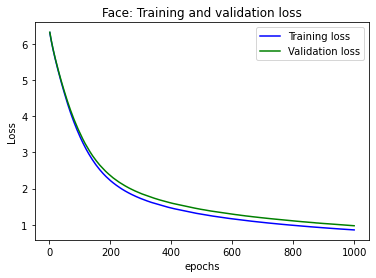

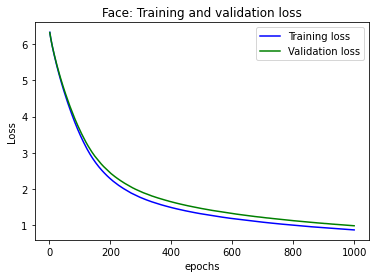

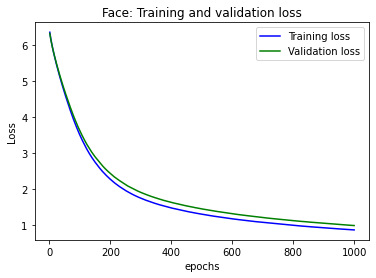

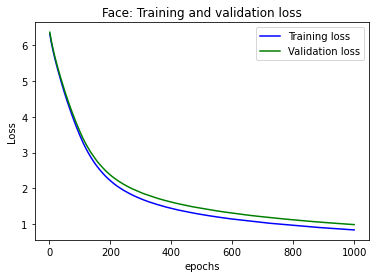

In [71]:
# Face Loss
for i in range(4):
    loss = all_history_face[i].get('loss') # train
    val_loss = all_history_face[i].get('val_loss') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation loss') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Face: Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

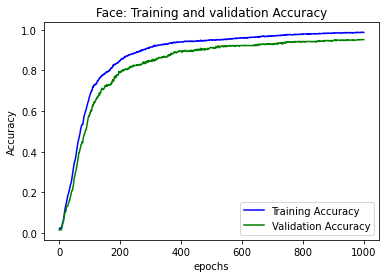

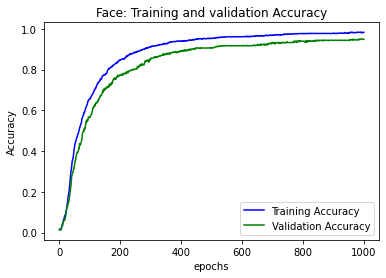

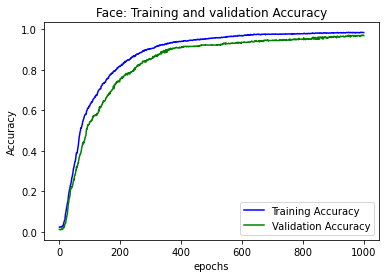

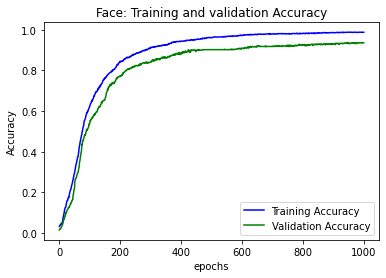

In [72]:
# Face Accuracy
for i in range(4):
    accuracy = all_history_face[i].get('accuracy') # train
    val_accuracy = all_history_face[i].get('val_accuracy') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Face: Training and validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

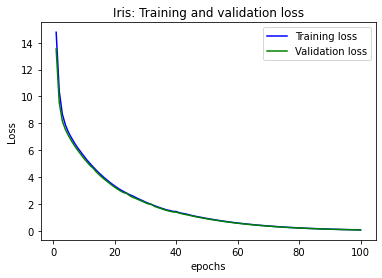

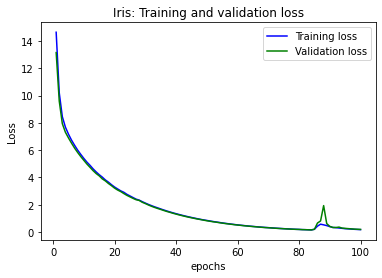

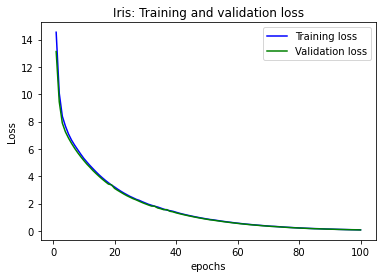

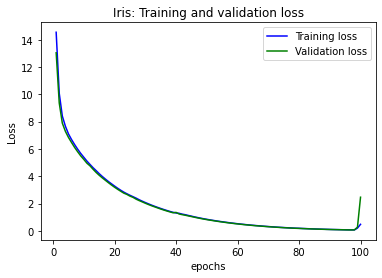

In [73]:
# Iris Loss
for i in range(4):
    loss = all_history_iris[i].get('loss') # train
    val_loss = all_history_iris[i].get('val_loss') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation loss') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Iris: Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

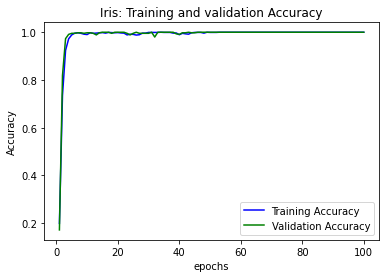

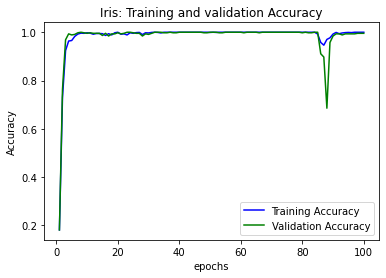

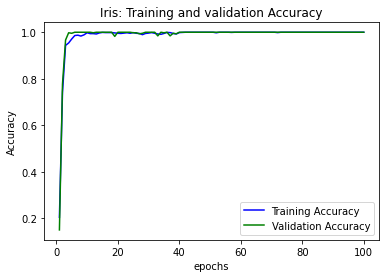

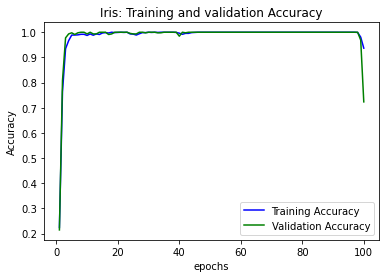

In [74]:
# Iris Accuracy
for i in range(4):
    accuracy = all_history_iris[i].get('accuracy') # train
    val_accuracy = all_history_iris[i].get('val_accuracy') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Iris: Training and validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [10]:
from tensorflow.keras.models import load_model
facemodel = load_model('./model/face_model3_3.h5') ## 가장 학습과정이 좋아보이는 모델 로드
irismodel = load_model('./model/iris_model3_3.h5')

In [77]:
# np.set_printoptions(precision=6, suppress=True) # 소수점표기

In [78]:
# test 예측
facepreds = facemodel.predict(X_test_face) # 0.64
irispreds = irismodel.predict(X_test_iris) # 0.65

In [79]:
preds = np.where(irispreds>facepreds, irispreds, facepreds) # 예측 확률이 높은쪽 선택
preds = np.argmax(preds, axis=1)
preds

array([41,  0, 60, 17,  3,  8, 27, 21, 43, 47,  4, 49, 12, 18, 53,  4, 14,
       19, 55, 54, 11, 14, 53, 27, 59, 27, 47,  8,  4,  2, 53,  3, 13, 11,
       52, 26, 25, 51, 33, 62, 62,  6, 36, 10,  7,  5,  1,  3, 17, 43, 31,
       14, 55, 63, 47, 15, 22, 48, 29, 51, 29, 28,  9, 58, 22, 28, 49, 33,
       52, 63, 13, 43, 62, 16, 48,  5,  0, 23, 16, 63, 41, 61, 37, 46, 20,
       21, 59, 57, 54, 14, 60, 38, 12,  9, 60, 16, 40, 44,  1, 14,  9, 13,
       38, 25, 42,  2,  1,  2,  3, 60, 62, 50, 39, 41, 17, 34,  3, 28, 39,
       60, 16, 61, 51, 52, 25, 22, 21, 40, 32, 48, 18, 33, 30,  8, 34, 36,
        0, 63, 11, 14, 47, 40, 39,  3, 58, 12, 14,  8, 45, 29, 31,  6, 27,
       34, 38, 18,  6, 44, 50, 47, 21, 29, 56, 47,  0, 35, 63, 53,  8, 11,
       36, 53, 11, 15, 46, 19, 63, 58, 35, 52,  9, 45,  5, 30, 37, 31,  3,
       37,  5, 24, 13, 40, 14, 61, 57, 38, 47, 29, 17, 16, 36, 18, 42, 41,
       30, 48,  5, 51, 55, 30, 52, 20, 38, 27, 55, 50, 25, 44, 50, 18, 22,
       29, 59, 52, 27, 31

In [80]:
y_test_data

array([41,  0, 60, 17,  3,  8, 27, 21, 43, 47,  4, 49, 12, 18, 53,  4, 14,
       19, 55, 54, 11, 14, 53, 27, 59, 27, 47,  8,  4,  2, 53,  3, 13, 11,
       52, 26, 25, 51, 33, 62, 62,  6, 36, 10,  7,  5,  1,  3, 17, 43, 31,
       14, 55, 63, 47, 15, 22, 48, 29, 51, 29, 28,  9, 58, 22, 28, 49, 33,
       52, 63, 13, 43, 62, 16, 48,  5,  0, 23, 16, 63, 41, 61, 37, 46, 20,
       21, 59, 57, 54, 14, 60, 38, 12,  9, 60, 16, 40, 44,  1, 14,  9, 13,
       38, 25, 42,  2,  1,  2,  3, 60, 62, 50, 39, 41, 17, 34,  3, 28, 39,
       60, 16, 61, 51, 52, 25, 22, 21, 40, 32, 48, 18, 33, 30,  8, 34, 36,
        0, 63, 11, 14, 47, 40, 39,  3, 58, 12, 14,  8, 45, 29, 31,  6, 27,
       34, 38, 18,  6, 44, 50, 47, 21, 29, 56, 47,  0, 35, 63, 53,  8, 11,
       36, 53, 11, 15, 46, 19, 63, 58, 35, 52,  9, 45,  5, 30, 37, 31,  3,
       37,  5, 24, 13, 40, 14, 61, 57, 38, 47, 29, 17, 16, 36, 18, 42, 41,
       30, 48,  5, 51, 55, 30, 52, 20, 38, 27, 55, 50, 25, 44, 50, 18, 22,
       29, 59, 52, 27, 31

(56, 46, 3)
예측:  41
실제:  41


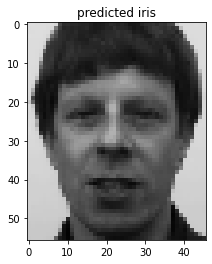

In [81]:
# 예측결과
plt.title('predicted iris')
this_img = X_test_face[0]
plt.imshow(this_img, cmap='gray')
print(this_img.shape)
print('예측: ', preds[0])
print('실제: ', y_test_data[0])

# Result

In [82]:
from sklearn.metrics import mean_squared_error
# rmse
rmse = np.sqrt(mean_squared_error(y_test_data, preds)) 
print("RMSE: %f" % (rmse))

RMSE: 0.000000


In [83]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_data,preds))

[[12  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0 12]]


In [84]:
from sklearn.metrics import classification_report
print(classification_report(y_test_data,preds, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        12
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        12
          14       1.00      1.00      1.00        12
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00        12
          17       1.00    

## Test

In [4]:
# 이미지 목록
images_face = sorted(glob.glob('./04_multimodal_test/*face.png'))
images_iris = sorted(glob.glob('./04_multimodal_test/*iris.png'))

print(len(images_face), len(images_iris))

64 64


In [5]:
r = re.compile('\d+')

img_face_t = [] # 이미지
img_iris_t = [] # 이미지
num_face_t = [] # 라벨
num_iris_t = [] # 라벨

for fname in images_face:
    l = r.findall(fname)[1]
    num_face_t.append(l)
    im = pilimg.open(fname)
    pix = np.array(im)/255.
    pix = pix.reshape(pix.shape[0], pix.shape[1], 1)
    pix = tf.image.grayscale_to_rgb(tf.convert_to_tensor(pix)) # ResNet50 위해 rgb 이미지로 변환
    img_face_t.append(pix)
    
for fname in images_iris:
    l = r.findall(fname)[1]
    num_iris_t.append(l)
    im = pilimg.open(fname)
    im = im.resize((int(im.width*0.3), int(im.height*0.3))) # 이미지 줄이기
    pix = np.array(im)/255. # Normalize
    img_iris_t.append(pix)

(56, 46, 3)
0


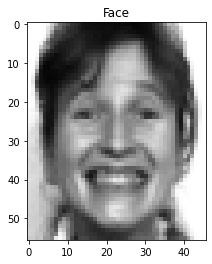

In [6]:
# 0번 사람의 얼굴 이미지
plt.title('Face')
plt.imshow(img_face_t[0])
print(img_face_t[0].shape)
print(num_face_t[0])

(172, 230, 3)
0


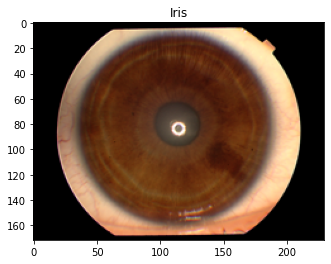

In [7]:
# 0번 사람의 홍채 이미지
plt.title('Iris')
plt.imshow(img_iris_t[0], cmap='gray')
print(img_iris_t[0].shape)
print(num_iris_t[0])

In [8]:
face_t = np.array(img_face_t)
iris_t = np.array(img_iris_t)
face_t = face_t.astype('float32')
iris_t = iris_t.astype('float32')

In [11]:
facepreds = facemodel.predict(face_t)
irispreds = irismodel.predict(iris_t)

preds = np.where(irispreds>facepreds, irispreds, facepreds) # 예측 확률이 높은쪽 선택
preds = np.argmax(preds, axis=1)
preds

array([27, 36,  2, 46, 50, 10, 61, 49, 59, 56, 13, 31, 37, 30, 25,  0, 41,
       58,  9, 20, 48, 47, 22, 42, 24,  3,  6, 55, 63, 21, 16, 34, 11, 57,
       35, 32, 40, 62, 19, 52, 33, 15,  1, 29, 54, 17, 26, 53, 28, 18, 14,
       43, 60,  4, 39, 45, 38, 23, 51, 44,  5, 12,  8,  7])

In [12]:
import pandas as pd
res_df = pd.DataFrame(num_face_t, columns=['Image'], dtype='int32')
res_df['Answer'] = pd.Series(preds, dtype='int32')
res_df.sort_values(by=['Image'], axis=0, inplace=True)
res_df

,Image,Answer
0,0,27
11,1,31
22,2,22
33,3,57
44,4,54
...,...,...
54,59,39
56,60,38
57,61,23
58,62,51


In [13]:
res_df['Answer'].value_counts()

0     1
1     1
34    1
35    1
36    1
     ..
26    1
27    1
28    1
29    1
63    1
Name: Answer, Length: 64, dtype: int64

In [14]:
res_df.to_csv('./1871085_멀티모달_1차_답안_모델2개_3.csv', index=False)